In [48]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy import odr
import pylustrator

In [71]:
# cap = cv.VideoCapture("./untitled.mp4")
save = False
maxCorners = 80
cap = cv.VideoCapture("rotation murement wih-beam plate 2.mp4")
fps = 30

In [72]:
# params for ShiTomasi corner detection
feature_params = dict(
    maxCorners=maxCorners, qualityLevel=0.7, minDistance=7, blockSize=7
)

# Parameters for lucas kanade optical flow
lk_params = dict(
    winSize=(15, 15),
    maxLevel=2,
    criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03),
)

# Create some random colors
color = np.random.randint(0, 255, (100, 3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
start = p0
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
ctr = 0
pointtracker = {}
wayfinder = {}
first = True
start = []
while 1:
    # read and process frames
    ret, frame = cap.read()
    if not ret:
        print("No frames grabbed!")
        break
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # filter good points only
    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        if first:
            start.append(tuple(old.ravel()))
        wayfinder[tuple(old.ravel())] = tuple(new.ravel())
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
        if tuple(color[i]) not in pointtracker:
            pointtracker[tuple(color[i])] = []
        pointtracker[tuple(color[i])].append((int(c), int(d)))
    
    img = cv.add(frame, mask)
    
    first = False
    
    cv.imshow("frame", img)
    if save:
        cv.imwrite("./frames2/" + str(ctr) + ".png", img)

    k = cv.waitKey(30) & 0xFF
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
    ctr += 1

cv.destroyAllWindows()

No frames grabbed!


## initial locations for pathfinder

In [73]:
start, len(start)

([(1118.0, 754.0),
  (1142.0, 670.0),
  (1107.0, 639.0),
  (1104.0, 747.0),
  (1136.0, 651.0),
  (1039.0, 715.0),
  (1059.0, 614.0),
  (1172.0, 670.0),
  (1179.0, 657.0),
  (1065.0, 601.0),
  (1153.0, 709.0),
  (1090.0, 645.0),
  (1026.0, 708.0),
  (1095.0, 664.0),
  (1159.0, 696.0),
  (1117.0, 660.0),
  (854.0, 195.0),
  (1130.0, 634.0),
  (832.0, 240.0),
  (1104.0, 619.0),
  (1172.0, 641.0),
  (1148.0, 657.0),
  (1128.0, 663.0),
  (1165.0, 684.0),
  (1097.0, 632.0),
  (1052.0, 690.0),
  (463.0, 1020.0),
  (1091.0, 741.0),
  (1088.0, 677.0),
  (1222.0, 1400.0),
  (1101.0, 651.0),
  (1149.0, 690.0),
  (1135.0, 683.0),
  (1090.0, 612.0),
  (1107.0, 609.0),
  (1123.0, 648.0),
  (1123.0, 677.0),
  (1142.0, 638.0),
  (1071.0, 651.0),
  (1161.0, 664.0),
  (1114.0, 625.0),
  (1142.0, 702.0),
  (1052.0, 628.0),
  (1046.0, 703.0),
  (1052.0, 721.0),
  (1081.0, 596.0),
  (1065.0, 664.0),
  (1140.0, 735.0),
  (1070.0, 618.0),
  (1095.0, 603.0),
  (1069.0, 715.0),
  (970.0, 933.0),
  (1033.0, 666

## find all paths

In [74]:
all_points = set(wayfinder)
paths = []
for idx, beg in enumerate(start):
    paths.append([beg])
    find = tuple(beg)
    while find in all_points:
        all_points.discard(find)
        paths[idx].append(tuple(find))
        find = tuple(wayfinder[find])

    all_points.discard(find)

(0.0, 1080.0)

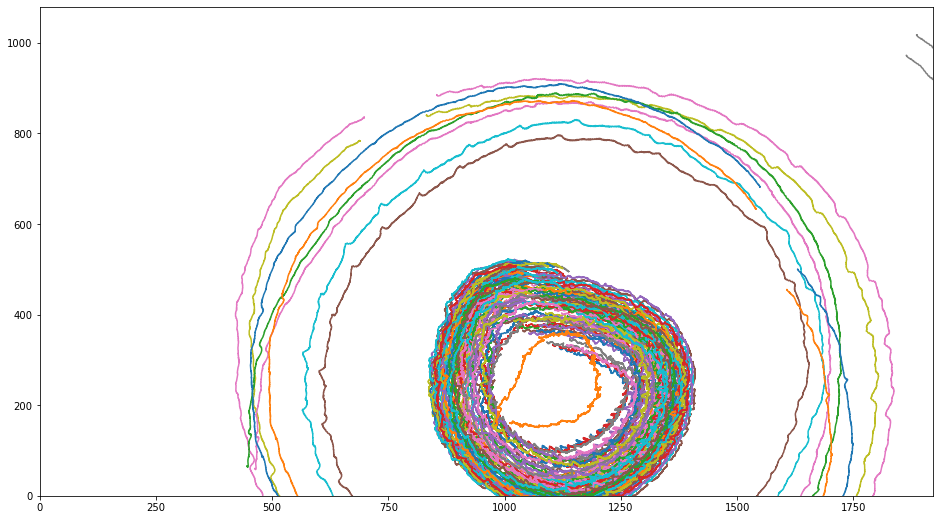

In [75]:
plt.subplots(figsize=[16, 9])

for x in paths:
    arr = np.array(x)
    x = arr[:, 0]
    y = 1080 - arr[:, 1]
    plt.plot(x, y)

plt.xlim(0, 1920)
plt.ylim(0, 1080)

In [76]:
def calc_R(xc, yc):
    """ calculate the distance of each data points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f_3(beta, x):
    """ implicit definition of the circle """
    return (x[0]-beta[0])**2 + (x[1]-beta[1])**2 -beta[2]**2

def fit_circle(x,y):
    x_m = 1200
    y_m = 122
    # initial guess for parameters
    R_m = calc_R(x_m, y_m).mean()
    beta0 = [ x_m, y_m, R_m]

    # for implicit function :
    #       data.x contains both coordinates of the points (data.x = [x, y])
    #       data.y is the dimensionality of the response
    lsc_data  = odr.Data(np.row_stack([x, y]), y=1)
    lsc_model = odr.Model(f_3, implicit=True)
    lsc_odr   = odr.ODR(lsc_data, lsc_model, beta0)
    lsc_out   = lsc_odr.run()

    xc_3, yc_3, R_3 = lsc_out.beta
    return lsc_out.beta

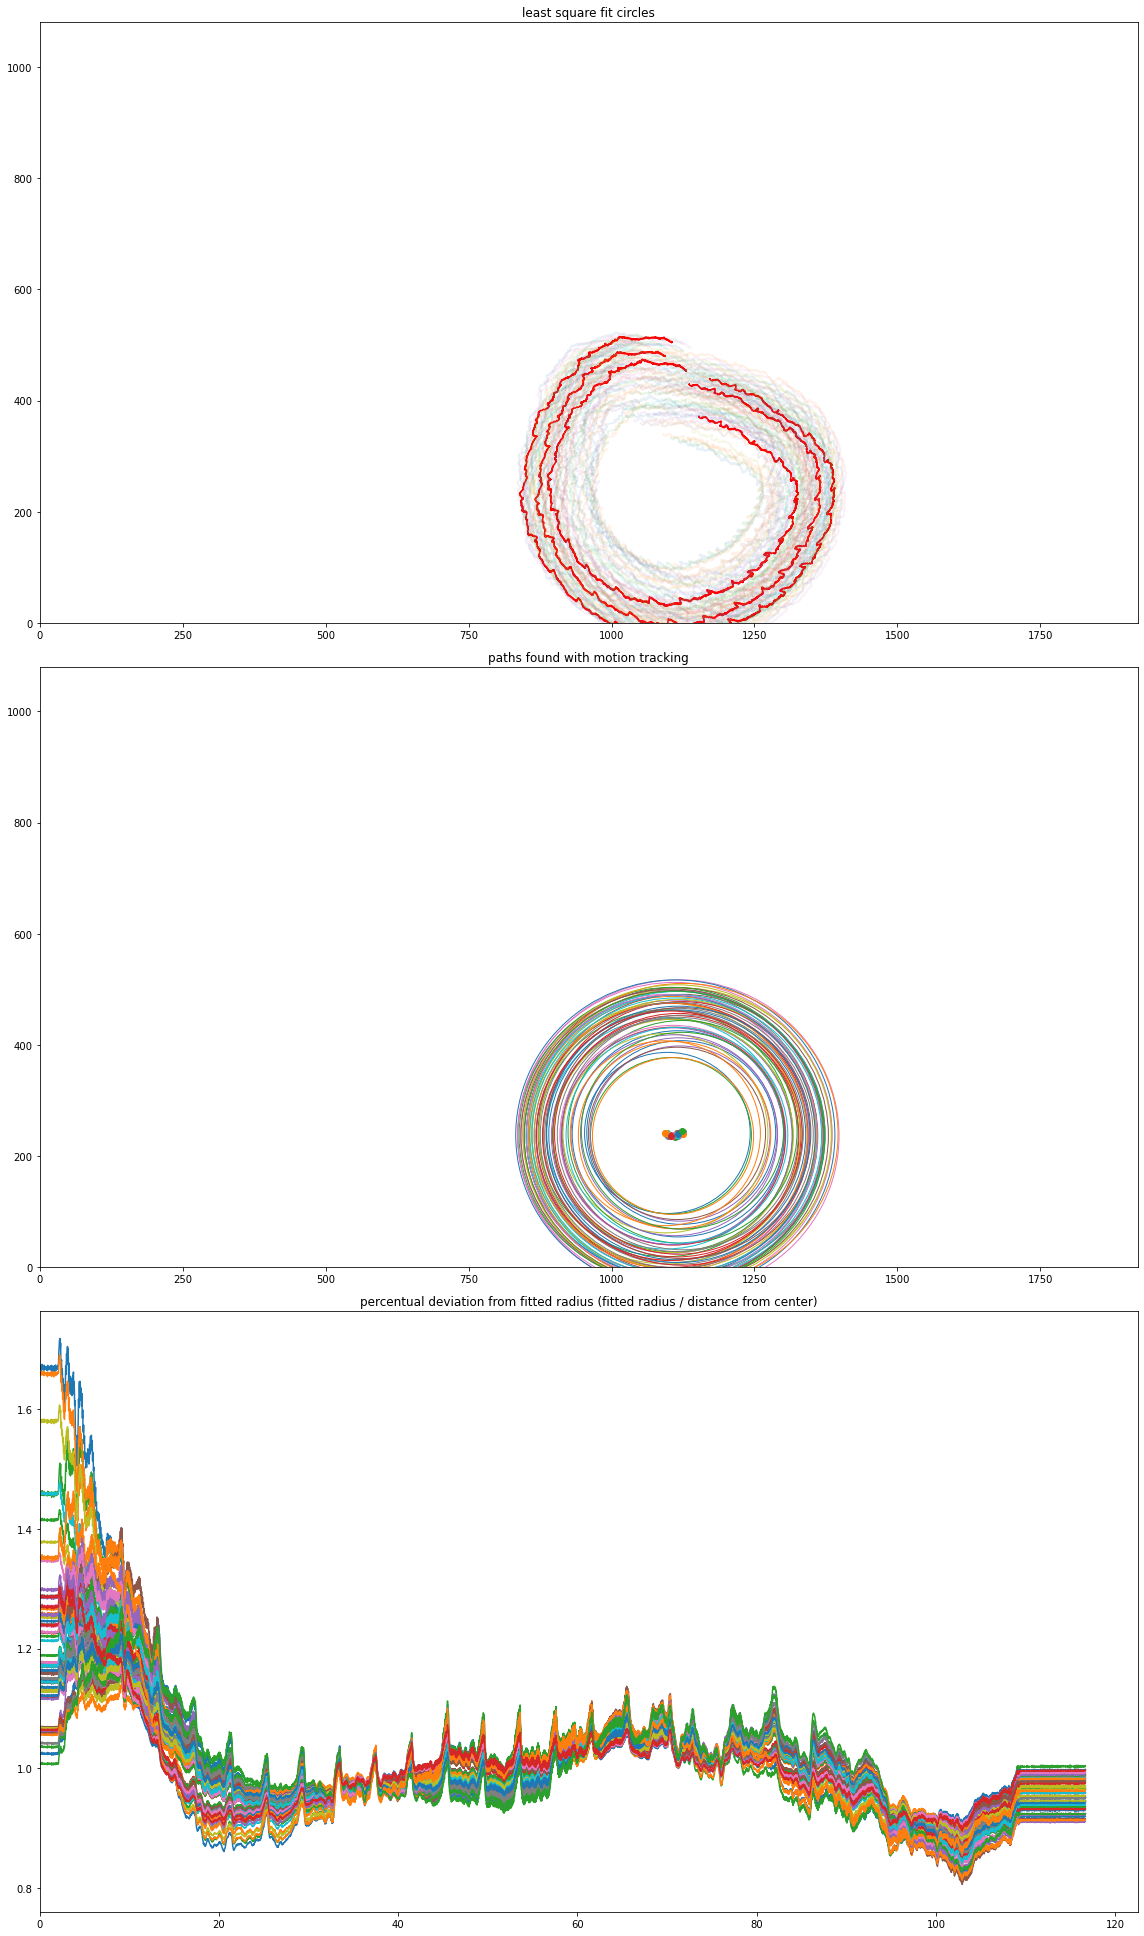

In [90]:
maxi = max(map(len, paths))
maxdiff = 8

fig, (ax3, ax1, ax2) = plt.subplots(3, 1, figsize=[16, 9 * 3])

sig = []
found_circles = []

orange = [1, 11,21, 31,41,51,62]

special = [10, 20,4]

for idx, prearr in enumerate(paths):
    arr = np.array(prearr)
    #     if len(arr) != maxi:
    #         continue
    #     x = 1920 - arr[:,0]
    x = arr[:, 0]
    y = 1080 - arr[:, 1]
    if any(np.diff(x) > maxdiff) or any(np.diff(y) > maxdiff):
        continue
    if idx in orange:
        continue

    xc, yc, R = fit_circle(x, y)
    if xc < 1250 and len(x)>2000 and R < 500:
#         print(len(x))e
        p = ax1.scatter(xc, yc)
        c = p.get_facecolor()[0, :3]
        circ = plt.Circle((xc, yc), R, color=c, fill=False)
        found_circles.append((xc, yc, R, c))
        ax1.add_artist(circ)
        t = np.linspace(0, len(x) / fps-1/fps, len(x))
        ax2.plot(t, R / (np.sqrt((x - xc) ** 2 + (y - yc) ** 2)), color=c, label=idx)
        sig.append((t, R / (np.sqrt((x - xc) ** 2 + (y - yc) ** 2))))
        if idx in special:
            ax3.plot(x, y, color='r')
        else:
            ax3.plot(x, y, color=c, alpha=0.1)


ax1.set_ylim(0, 1080)
ax1.set_xlim(0, 1920)
ax1.set_title("paths found with motion tracking")


ax2.set_title("percentual deviation from fitted radius (fitted radius / distance from center)")
# ax2.legend()
ax2.set_xlim(0)

ax3.set_ylim(0, 1080)
ax3.set_xlim(0, 1920)
ax3.set_title("least square fit circles")

plt.tight_layout()
plt.show()

## test signal

In [58]:
# Number of sample points
N = len(s)
# sample spacing
T = 1.0 / fps

t = np.linspace(0.0, N * T, N)

s = np.sin(50*t) + np.sin(2*t)+np.sin(90*t)

yf = scipy.fftpack.fft(s)
xf = np.linspace(0.0, 1.0 // (2.0 * T), N // 2)

ax.plot(xf, 2.0 / N * np.abs(yf[: N // 2]))

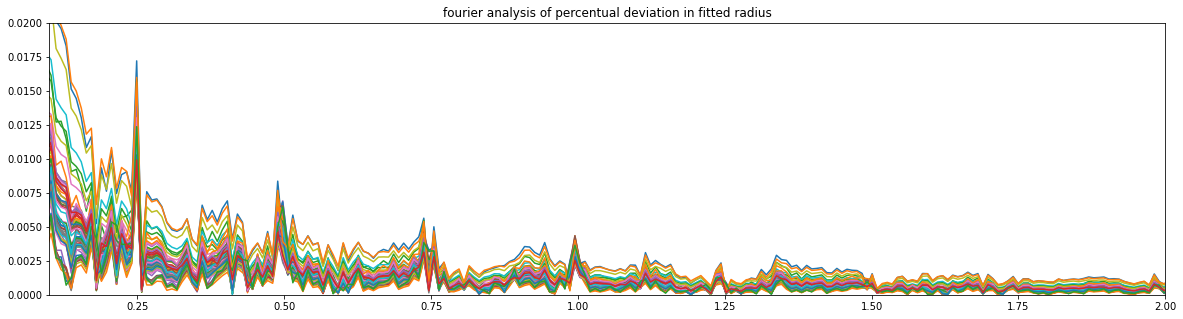

In [104]:
fig, ax = plt.subplots(figsize=[20,5])
for t,s in sig:
    # Number of sample points
    N = len(s)
    # sample spacing
    T = 1.0 / fps
    
    t = np.linspace(0.0, N * T, N)
    
    yf = scipy.fftpack.fft(s)
    xf = np.linspace(0.0, 1.0 // (2.0 * T), N // 2)

    ax.plot(xf, 2.0 / N * np.abs(yf[: N // 2]))

plt.title("fourier analysis of percentual deviation in fitted radius")
plt.xlim(0.1,2)
plt.ylim(0,0.02)
plt.show()

In [60]:
with open('sig_test.txt','w') as f:
    for line in s:
        f.write(str(line))

***
# try out

In [181]:
print("           sd_beta: {}".format(lsc_out.sd_beta))
print("sqrt(diag(sd_cov)): {}".format(np.sqrt(np.diag(lsc_out.cov_beta))))

           sd_beta: [0.55410726 1.32922917 0.98340051]
sqrt(diag(sd_cov)): [0.04981424 0.1194977  0.0884077 ]
